<a href="https://colab.research.google.com/github/samy387/Arabian/blob/main/Neural_Project_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [ ]:
data_dir = '/content/drive/MyDrive/neural network/Gesture Image Data'
Name = os.listdir(data_dir)
print(Name)

['6', '8', '1', '5', '2', '3', '9', '0', '7', '4', 'J', 'B', 'G', 'I', 'E', 'F', 'C', 'D', 'A', 'H', 'Q', 'M', 'R', 'O', 'T', 'L', 'P', 'K', 'S', 'N', '_', 'X', 'Z', 'W', 'Y', 'U', 'V']


In [ ]:
N = list(range(len(Name)))
normal_mapping = dict(zip(Name,N))
reverse_mapping = dict(zip(N,Name))

(50, 50, 3)


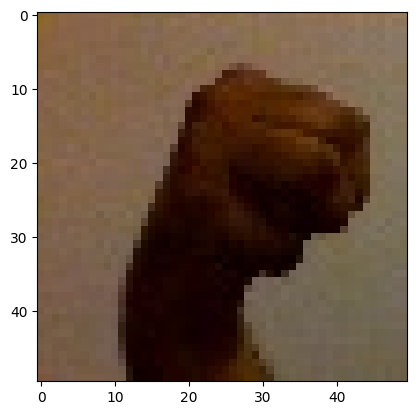

In [ ]:
path_to_a_random_image = '/content/drive/MyDrive/neural network/Gesture Image Data/M/10.jpg'
image=cv2.imread(path_to_a_random_image)
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
dataset = []
dataname = []

count=0

for name in tqdm(os.listdir(data_dir)):

    path=os.path.join(data_dir,name)

    for im in os.listdir(path):
        image=cv2.imread(os.path.join(path,im))
        dataset += [image]
        dataname += [count]

    count=count+1

100%|██████████| 37/37 [07:12<00:00, 11.68s/it]


In [ ]:
data = np.array(dataset)
dataname = np.array(dataname)

In [ ]:
print(pd.Series(dataname).value_counts())

15    507
0     500
27    500
21    500
22    500
23    500
24    500
25    500
26    500
28    500
19    500
29    500
30    500
31    500
32    500
33    500
34    500
35    500
20    500
18    500
1     500
8     500
2     500
3     500
4     500
5     500
6     500
7     500
9     500
17    500
10    500
11    500
12    500
13    500
14    500
16    500
36    500
Name: count, dtype: int64


In [ ]:
data_length = len(data)  #m
M = list(range(data_length))
random.seed(2021)
random.shuffle(M)

In [ ]:
# Define the indices for splitting data (train and test split)
train_index = M[0:(data_length // 4) * 3]
test_index = M[(data_length // 4) * 3:]

# Split data into training and testing sets
train_features = data[train_index]
train_labels = dataname[train_index]

test_features = data[test_index]
test_labels = dataname[test_index]

In [ ]:
# Convert training labels to categorical and create numpy array
train_labels_categorical = to_categorical(train_labels)
train_labels_array = np.array(train_labels_categorical)

In [ ]:
train_labels_categorical

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_labels_array

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Split training data into train and validation sets
trainX, valX, trainY, valY = train_test_split(train_features, train_labels_array, test_size=0.2, random_state=42)

In [ ]:
# Create an ImageDataGenerator for data augmentation

data_generator = ImageDataGenerator(
    horizontal_flip=True,      # Randomly flip input images horizontally
    vertical_flip=True,        # Randomly flip input images vertically
    rotation_range=20,         # Rotate images up to 20 degrees
    zoom_range=(0.8, 1.2),     # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,     # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Shift images vertically by up to 20% of the height
    shear_range=0.1,           # Shear transformation by up to 10%
    fill_mode='nearest'        # Fill any newly created pixels after transformation with nearest neighbors
)

In [ ]:
# Load a pretrained MobileNetV2 model without the top layer
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(50, 50, 3),  # Input shape for the model (image dimensions: 50x50 with 3 color channels)
    include_top=False,        # Do not include the fully connected top layer
    weights='imagenet',       # Load pretrained weights from the ImageNet dataset
    pooling='avg'             # Apply global average pooling to the output
)

# Freeze the pretrained model to prevent its layers from being updated during training
pretrained_model.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Build a custom model on top of the pretrained VGG16 model
inputs = pretrained_model.input  # Use the input layer of the pretrained model

# Add a new fully connected layer for feature extraction
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)

# Add the output layer with softmax activation for classification
outputs = tf.keras.layers.Dense(len(Name), activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the model with optimizer, loss function, and metrics
model.compile(
    optimizer='adam',                  # Use Adam optimizer for training
    loss='categorical_crossentropy',   # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']               # Track accuracy during training
)

In [ ]:
history = model.fit(
    data_generator.flow(trainX, trainY, batch_size=32),  # Train the model using augmented data
    validation_data=(valX, valY),                        # Use validation data for validation
    epochs=20                                            # Train for 20 epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


347/347 ━━━━━━━━━━━━━━━━━━━━ 205s 520ms/step - accuracy: 0.3564 - loss: 2.3531 - val_accuracy: 0.7990 - val_loss: 0.7368
Epoch 2/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 172s 495ms/step - accuracy: 0.7239 - loss: 0.8730 - val_accuracy: 0.8368 - val_loss: 0.5209
Epoch 3/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 162s 466ms/step - accuracy: 0.7902 - loss: 0.6444 - val_accuracy: 0.8483 - val_loss: 0.4722
Epoch 4/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 172s 495ms/step - accuracy: 0.8267 - loss: 0.5328 - val_accuracy: 0.8386 - val_loss: 0.5063
Epoch 5/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 192s 467ms/step - accuracy: 0.8477 - loss: 0.4643 - val_accuracy: 0.8401 - val_loss: 0.4409
Epoch 6/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 215s 504ms/step - accuracy: 0.8463 - loss: 0.4651 - val_accuracy: 0.8238 - val_loss: 0.4834
Epoch 7/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 190s 470ms/step - accuracy: 0.8660 - loss: 0.3996 - val_accuracy: 0.8599 - val_loss: 0.4406
Epoch 8/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 171s 492ms/step - accuracy: 0.8736 - loss: 0.38

In [ ]:
# Predict on the test set
y_pred = model.predict(test_features)
predictions = np.argmax(y_pred, axis=1)
test_labels_categorical = to_categorical(test_labels)
ground_truth = np.argmax(test_labels_categorical, axis=1)  # Use categorical test labels for ground truth comparison

145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 382ms/step


In [ ]:
# Calculate and print metrics including top-k accuracy
top_1_accuracy = tf.keras.metrics.Accuracy()(ground_truth, predictions)
y_pred_top_2 = np.argsort(y_pred, axis=1)[:, -2:]
y_pred_top_3 = np.argsort(y_pred, axis=1)[:, -3:]
top_2_accuracy = np.mean([ground_truth[i] in y_pred_top_2[i] for i in range(len(ground_truth))])
top_3_accuracy = np.mean([ground_truth[i] in y_pred_top_3[i] for i in range(len(ground_truth))])

print(f"Top-1 Accuracy: {top_1_accuracy:.2%}")
print(f"Top-2 Accuracy: {top_2_accuracy:.2%}")
print(f"Top-3 Accuracy: {top_3_accuracy:.2%}")

# Print the classification report
print(classification_report(ground_truth, predictions))

Top-1 Accuracy: 89.83%
Top-2 Accuracy: 96.35%
Top-3 Accuracy: 98.64%
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       104
           1       0.67      0.99      0.80       122
           2       1.00      1.00      1.00       111
           3       0.99      1.00      1.00       137
           4       1.00      1.00      1.00       134
           5       1.00      0.77      0.87       132
           6       1.00      1.00      1.00       130
           7       1.00      0.96      0.98       148
           8       0.44      0.72      0.55       128
           9       0.99      1.00      0.99       133
          10       0.88      0.84      0.86       118
          11       1.00      1.00      1.00       126
          12       0.96      0.87      0.92       119
          13       0.76      0.88      0.81       112
          14       1.00      0.98      0.99       125
          15       0.89      0.53      0.66       121
          16

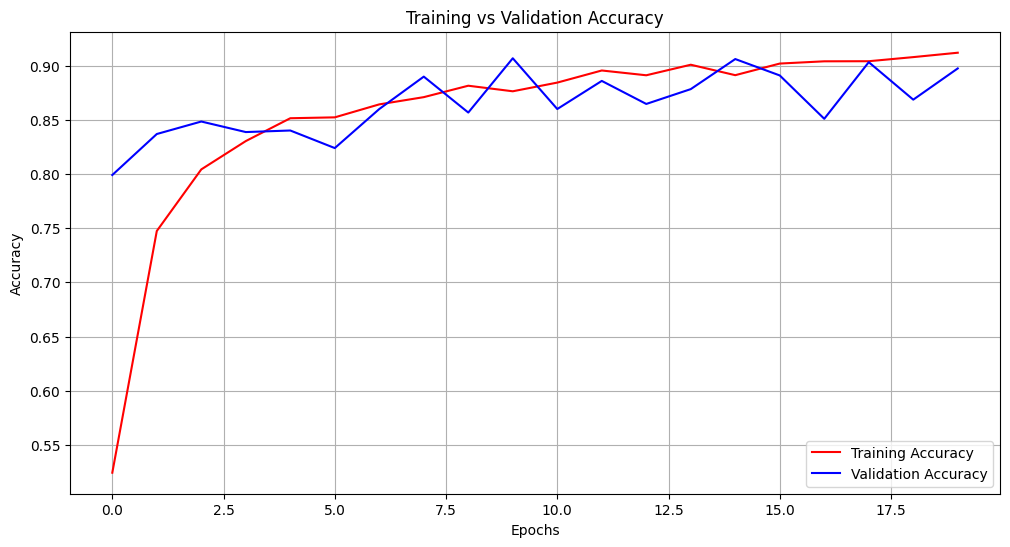

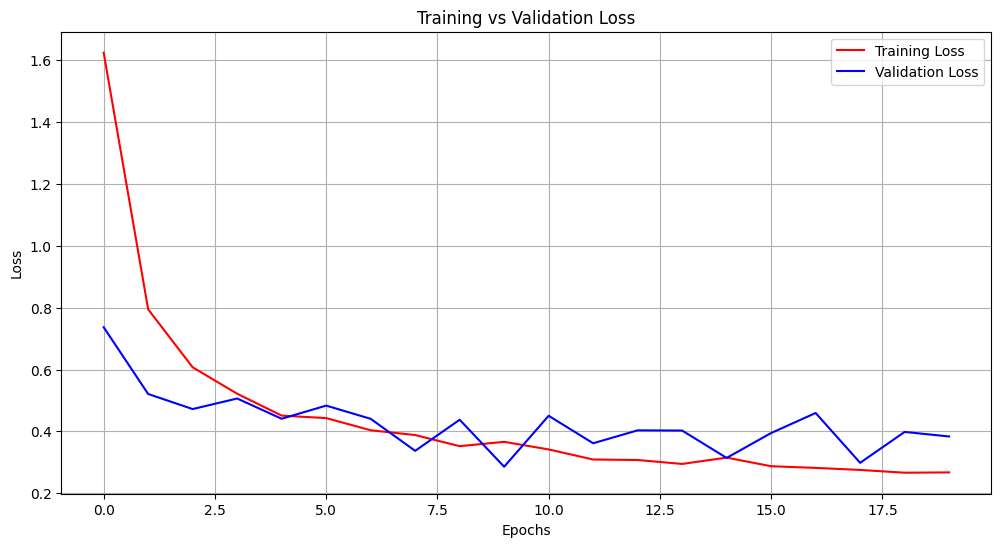

In [ ]:
# Plot training and validation accuracy over epochs
get_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
get_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
epochs = range(len(get_acc))
plt.figure(figsize=(12, 6))
plt.plot(epochs, get_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, get_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Additional prediction analysis on the test set
pred2 = model.predict(test_features)
print(pred2.shape)

# Convert predictions to class labels
PRED = [np.argmax(item) for item in pred2]

# Print the count of each predicted class
print(pd.Series(PRED).value_counts())

145/145 ━━━━━━━━━━━━━━━━━━━━ 51s 354ms/step
(4629, 37)
8     207
24    192
1     180
27    161
30    154
35    148
7     142
26    139
3     138
32    136
9     135
4     134
25    131
6     130
33    129
13    129
34    127
11    126
18    126
21    125
19    125
14    123
29    123
36    122
20    121
23    119
17    115
28    115
10    112
2     111
12    108
5     102
22     94
31     94
16     79
15     72
0       5
Name: count, dtype: int64


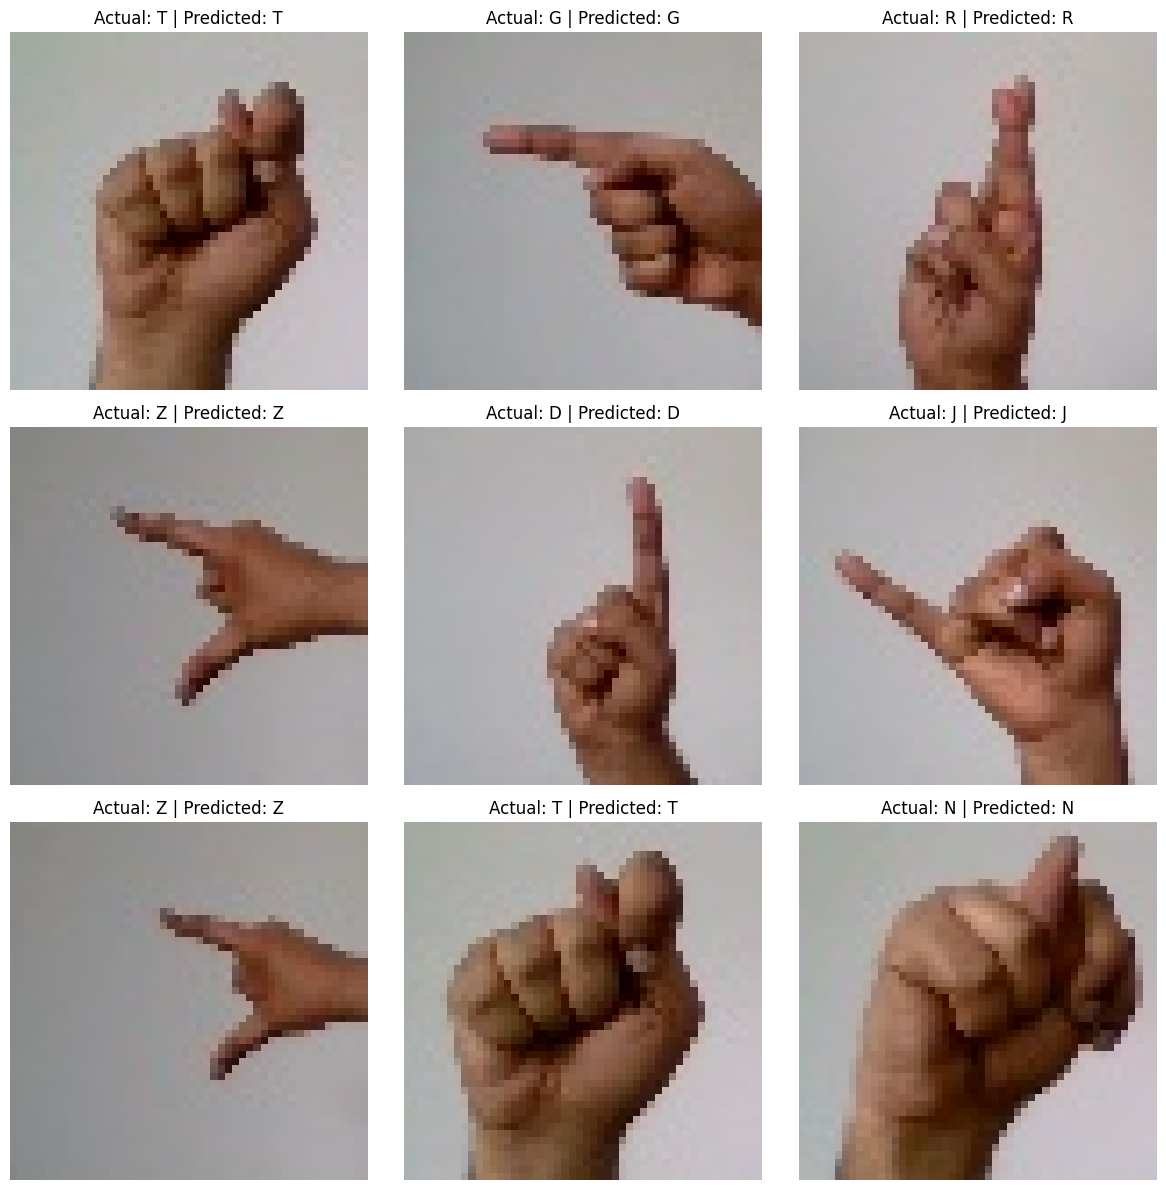

In [ ]:
# Plot images with their actual and predicted labels
def plot_images_with_predictions(test_images, actual_labels, predicted_labels, reverse_mapping, num_images=9):
    """
    Plots a grid of images with their actual and predicted labels.

    Parameters:
    - test_images: Array of test images
    - actual_labels: Array of actual labels (indices)
    - predicted_labels: Array of predicted labels (indices)
    - reverse_mapping: Mapping from label indices to their corresponding class names
    - num_images: Number of images to display (default is 9)
    """
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(min(num_images, len(test_images))):
        r = i // 3
        c = i % 3
        img = test_images[i]
        axs[r][c].axis("off")

        actual = reverse_mapping[actual_labels[i]]
        predict = reverse_mapping[predicted_labels[i]]
        axs[r][c].set_title(f'Actual: {actual} | Predicted: {predict}')
        axs[r][c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have reverse_mapping defined
plot_images_with_predictions(test_features, ground_truth, PRED, reverse_mapping, num_images=9)

In [ ]:
# Check the shape of the prediction and the true labels
print("Shape of test_features:", test_features.shape)
print("Shape of test_labels_categorical:", test_labels_categorical.shape)
print("Shape of pred2:", pred2.shape)

# Ensure the prediction is for the same `test_features` used in train_test_split
pred5 = model.predict(test_features)  # Use test_features here, not testX
print("New shape of pred5:", pred5.shape)

# Convert predictions to class labels
PREDICT = [np.argmax(item) for item in pred5]

# Make sure `test_labels_categorical` is in the correct format (as class labels, not one-hot)
ground_truth = np.argmax(test_labels_categorical, axis=1)  # Convert one-hot to labels if needed

Shape of test_features: (4629, 50, 50, 3)
Shape of test_labels_categorical: (4629, 37)
Shape of pred2: (4629, 37)
145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 339ms/step
New shape of pred5: (4629, 37)


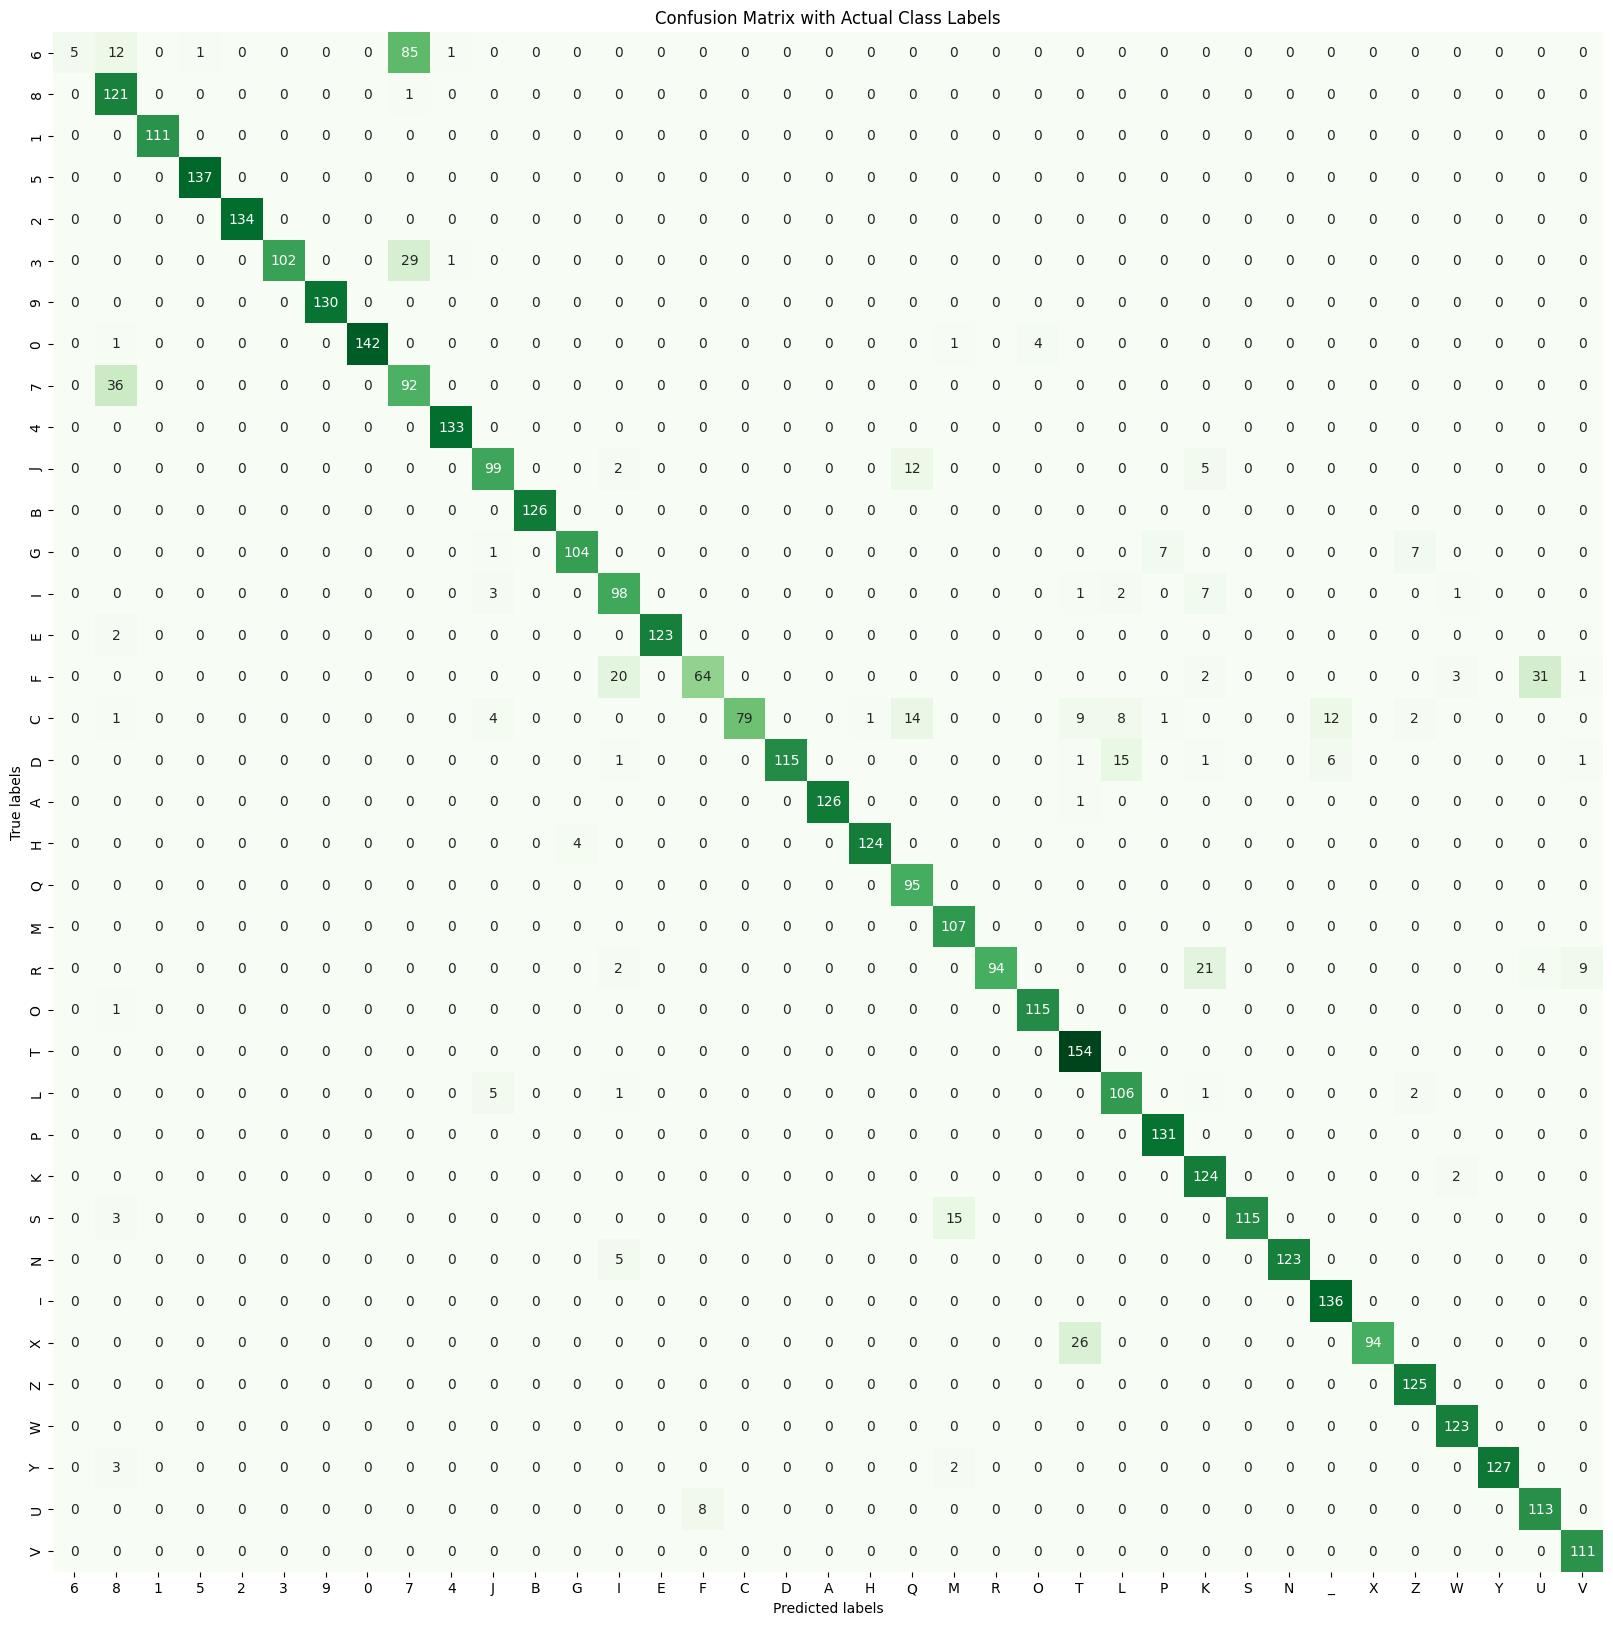

In [ ]:
# Import necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix with mapped labels
def plot_confusion_matrix(Y_test, Y_pred, label_mapping):
    # Generate the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)

    # Convert numerical labels to actual class labels using reverse_mapping
    labels = [label_mapping[i] for i in range(len(label_mapping))]

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap='Greens',
        cbar=False,
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with Actual Class Labels')
    plt.show()

# Call the function
# Assuming `ground_truth` is your test labels and `PREDICT` is your predicted labels
plot_confusion_matrix(ground_truth, PREDICT, reverse_mapping)